In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet18
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 15
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

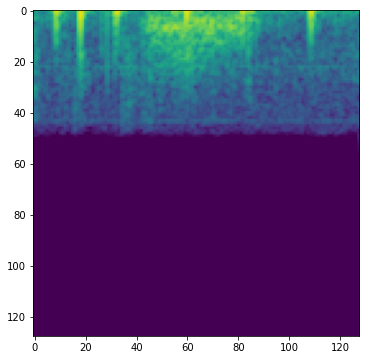

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.7656075725297875
TEST
loss: 0.6272342494555883
accuracy: 0.7587301587301587
******************
epoch: 1
Train
0.5690548212117292
TEST
loss: 0.8541568218715607
accuracy: 0.7238095238095238
******************
epoch: 2
Train
0.5036584728288689
TEST
loss: 1.5216401894887288
accuracy: 0.546031746031746
******************
epoch: 3
Train
0.424432601054762
TEST
loss: 1.3723322308252728
accuracy: 0.7142857142857143
******************
epoch: 4
Train
0.41104301779491736
TEST
loss: 0.9357511527954586
accuracy: 0.7365079365079366
******************
epoch: 5
Train
0.35963445840325026
TEST
loss: 0.530987037458117
accuracy: 0.7777777777777778
******************
epoch: 6
Train
0.2477328295836475
TEST
loss: 2.0194342212071494
accuracy: 0.4126984126984127
******************
epoch: 7
Train
0.2990308233771275
TEST
loss: 0.9651865660198151
accuracy: 0.7365079365079366
******************
epoch: 8
Train
0.2241754039021311
TEST
loss: 1.1029742793431359
accuracy: 0.6158730158730159
************

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8451776649746193


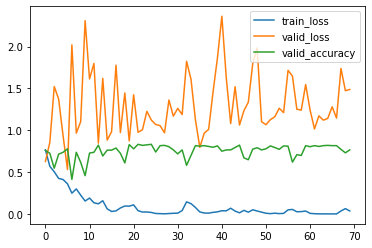

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8751479082395388
TEST
loss: 0.8066867351531982
accuracy: 0.7047619047619048
******************
epoch: 1
Train
0.6021904887141833
TEST
loss: 0.6660792803007459
accuracy: 0.7174603174603175
******************
epoch: 2
Train
0.5540029725164909
TEST
loss: 0.5604400411484733
accuracy: 0.7873015873015873
******************
epoch: 3
Train
0.5699157410429242
TEST
loss: 0.6525175955560473
accuracy: 0.7396825396825397
******************
epoch: 4
Train
0.4854673654953576
TEST
loss: 0.7863524228807479
accuracy: 0.707936507936508
******************
epoch: 5
Train
0.4539227572057435
TEST
loss: 0.6167845296481299
accuracy: 0.780952380952381
******************
epoch: 6
Train
0.39436485220081186
TEST
loss: 0.5647377689679464
accuracy: 0.8253968253968254
******************
epoch: 7
Train
0.3848481726513863
TEST
loss: 0.5847716367433942
accuracy: 0.7682539682539683
******************
epoch: 8
Train
0.3567356731420097
TEST
loss: 0.8783603779853336
accuracy: 0

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


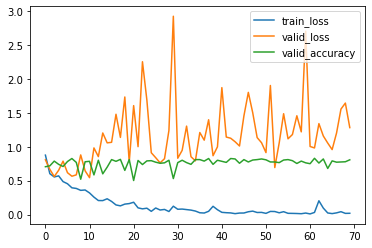

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8737855408757902
TEST
loss: 0.6701029743467058
accuracy: 0.7619047619047619
******************
epoch: 1
Train
0.5914297639802868
TEST
loss: 0.7148300267401195
accuracy: 0.7714285714285715
******************
epoch: 2
Train
0.4993907644977827
TEST
loss: 0.826078916920556
accuracy: 0.7206349206349206
******************
epoch: 3
Train
0.5306171207223458
TEST
loss: 0.5903828747688777
accuracy: 0.8
******************
epoch: 4
Train
0.4644005701975561
TEST
loss: 0.5302766621112823
accuracy: 0.8158730158730159
******************
epoch: 5
Train
0.41631073739625235
TEST
loss: 0.7109520083382016
accuracy: 0.6888888888888889
******************
epoch: 6
Train
0.39881551464556514
TEST
loss: 0.48039167693683077
accuracy: 0.7968253968253968
******************
epoch: 7
Train
0.3846747899713547
TEST
loss: 0.5653652864789206
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.35686663931754964
TEST
loss: 0.7732824369082375
accuracy: 0.7809523809

In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8553299492385786


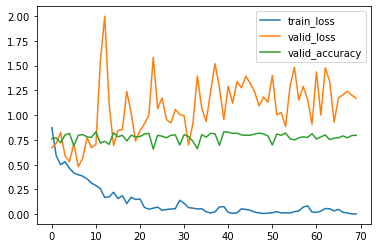

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.7905162253769927
TEST
loss: 0.6326131688223945
accuracy: 0.7619047619047619
******************
epoch: 1
Train
0.5351934618330646
TEST
loss: 0.87355040595645
accuracy: 0.7428571428571429
******************
epoch: 2
Train
0.47835652526642614
TEST
loss: 1.060741887206123
accuracy: 0.7365079365079366
******************
epoch: 3
Train
0.39928408148176997
TEST
loss: 0.6527645637118628
accuracy: 0.7841269841269841
******************
epoch: 4
Train
0.39131116968852553
TEST
loss: 1.1411952677227202
accuracy: 0.8063492063492064
******************
epoch: 5
Train
0.37287679196256224
TEST
loss: 0.949627145131429
accuracy: 0.7555555555555555
******************
epoch: 6
Train
0.2883254646592144
TEST
loss: 0.8572871537435622
accuracy: 0.7206349206349206
******************
epoch: 7
Train
0.1882872921995363
TEST
loss: 1.218275096870604
accuracy: 0.726984126984127
******************
epoch: 8
Train
0.18990641124576116
TEST
loss: 1.170657949977451
accuracy: 0.

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8375634517766497


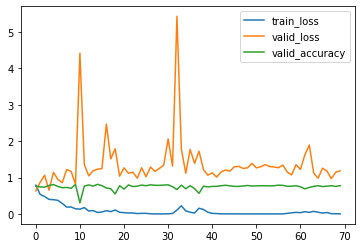

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8108392092232859
TEST
loss: 0.6522142646804688
accuracy: 0.7841269841269841
******************
epoch: 1
Train
0.5587839139085425
TEST
loss: 0.7539960123243786
accuracy: 0.7587301587301587
******************
epoch: 2
Train
0.4905026742539016
TEST
loss: 1.3874062803056506
accuracy: 0.5968253968253968
******************
epoch: 3
Train
0.4227148325695132
TEST
loss: 0.5385458271654825
accuracy: 0.7904761904761904
******************
epoch: 4
Train
0.38141408101067453
TEST
loss: 1.3060341301418485
accuracy: 0.6507936507936508
******************
epoch: 5
Train
0.3665620557153102
TEST
loss: 0.9036402248200917
accuracy: 0.7777777777777778
******************
epoch: 6
Train
0.2475206111990525
TEST
loss: 0.6585031187723553
accuracy: 0.7333333333333333
******************
epoch: 7
Train
0.25881003184248474
TEST
loss: 0.7714659111840384
accuracy: 0.8158730158730159
******************
epoch: 8
Train
0.19637010921742634
TEST
loss: 1.0833665480689396
accurac

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8426395939086294


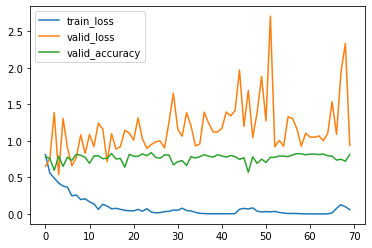

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9181047708293196
TEST
loss: 1.3425727091138324
accuracy: 0.3111111111111111
******************
epoch: 1
Train
0.6409669059245146
TEST
loss: 1.2068649030867078
accuracy: 0.6666666666666666
******************
epoch: 2
Train
0.5904744499917064
TEST
loss: 0.594717318103427
accuracy: 0.7682539682539683
******************
epoch: 3
Train
0.5443860000802753
TEST
loss: 0.857827103327191
accuracy: 0.7174603174603175
******************
epoch: 4
Train
0.5090278299958864
TEST
loss: 0.731435505738334
accuracy: 0.7428571428571429
******************
epoch: 5
Train
0.539349929527975
TEST
loss: 0.7264758015435839
accuracy: 0.7587301587301587
******************
epoch: 6
Train
0.4708552306563822
TEST
loss: 0.8084756374359131
accuracy: 0.7174603174603175
******************
epoch: 7
Train
0.4401943504905019
TEST
loss: 0.5420996800301567
accuracy: 0.819047619047619
******************
epoch: 8
Train
0.4573756515080253
TEST
loss: 1.120795230259971
accuracy: 0.6634

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.883248730964467


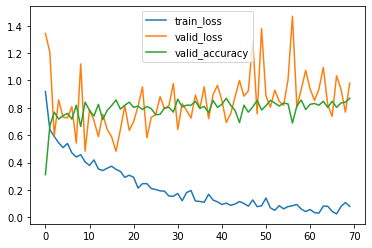

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9759970278471022
TEST
loss: 0.8632770458857218
accuracy: 0.6158730158730159
******************
epoch: 1
Train
0.7020542037401812
TEST
loss: 0.7455633473774743
accuracy: 0.746031746031746
******************
epoch: 2
Train
0.6578265855102146
TEST
loss: 1.1507783197221302
accuracy: 0.5333333333333333
******************
epoch: 3
Train
0.6486173713131497
TEST
loss: 0.6478983362515768
accuracy: 0.7587301587301587
******************
epoch: 4
Train
0.594551843721967
TEST
loss: 0.9633614479549347
accuracy: 0.7015873015873015
******************
epoch: 5
Train
0.596435224706924
TEST
loss: 0.6337016828476436
accuracy: 0.7714285714285715
******************
epoch: 6
Train
0.55707036317389
TEST
loss: 0.7140440195325821
accuracy: 0.6984126984126984
******************
epoch: 7
Train
0.5831402539260052
TEST
loss: 0.6177828298674689
accuracy: 0.7619047619047619
******************
epoch: 8
Train
0.5953234028873035
TEST
loss: 0.7633917352509877
accuracy: 0.730

In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


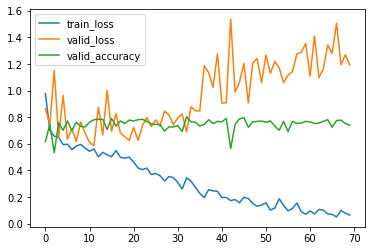

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9525675249061857
TEST
loss: 0.9522144862583706
accuracy: 0.6634920634920635
******************
epoch: 1
Train
0.7229563705120132
TEST
loss: 1.0043358231347705
accuracy: 0.6825396825396826
******************
epoch: 2
Train
0.6575968624865658
TEST
loss: 0.7439583352633885
accuracy: 0.6444444444444445
******************
epoch: 3
Train
0.5983249136291865
TEST
loss: 7.661636621989901
accuracy: 0.26031746031746034
******************
epoch: 4
Train
0.5902031342409451
TEST
loss: 0.773528331991226
accuracy: 0.7111111111111111
******************
epoch: 5
Train
0.6403938927188385
TEST
loss: 0.5920401232583182
accuracy: 0.7873015873015873
******************
epoch: 6
Train
0.5454006932196492
TEST
loss: 0.6537720379375276
accuracy: 0.7492063492063492
******************
epoch: 7
Train
0.4981040715745179
TEST
loss: 0.9375458021012564
accuracy: 0.6476190476190476
******************
epoch: 8
Train
0.47212940357430194
TEST
loss: 0.886796562255375
accuracy: 0

In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8477157360406091


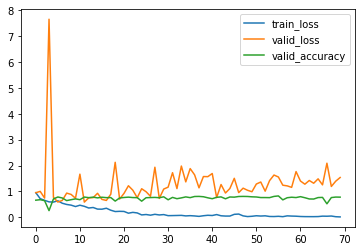

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8438376931560901
TEST
loss: 0.7757833586798774
accuracy: 0.707936507936508
******************
epoch: 1
Train
0.571973906896529
TEST
loss: 0.6339211910490006
accuracy: 0.7523809523809524
******************
epoch: 2
Train
0.4861105021512442
TEST
loss: 0.744770175880856
accuracy: 0.7619047619047619
******************
epoch: 3
Train
0.41532539618308817
TEST
loss: 0.8877883381313748
accuracy: 0.7047619047619048
******************
epoch: 4
Train
0.37164944070639166
TEST
loss: 0.8908546705094594
accuracy: 0.7111111111111111
******************
epoch: 5
Train
0.32276325930291644
TEST
loss: 0.7882099785501995
accuracy: 0.7492063492063492
******************
epoch: 6
Train
0.31562827470711624
TEST
loss: 0.6752958755644541
accuracy: 0.7492063492063492
******************
epoch: 7
Train
0.2944109224439898
TEST
loss: 0.711543950201973
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.2698309955448267
TEST
loss: 1.078667762165978
accuracy: 0

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


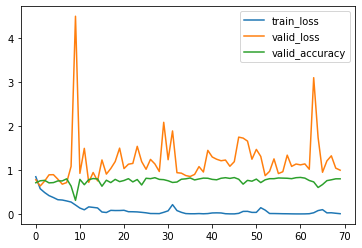

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8304374501570716
TEST
loss: 0.6842097096972996
accuracy: 0.7301587301587301
******************
epoch: 1
Train
0.5601060244183014
TEST
loss: 0.6086390126319159
accuracy: 0.7492063492063492
******************
epoch: 2
Train
0.485133353440273
TEST
loss: 0.6788174621642582
accuracy: 0.7587301587301587
******************
epoch: 3
Train
0.44394199624716807
TEST
loss: 0.898274240418086
accuracy: 0.6126984126984127
******************
epoch: 4
Train
0.4038702186324276
TEST
loss: 0.9290115278864663
accuracy: 0.7492063492063492
******************
epoch: 5
Train
0.3433524280478786
TEST
loss: 0.987880229571509
accuracy: 0.6
******************
epoch: 6
Train
0.30516935641136883
TEST
loss: 0.7417651942798069
accuracy: 0.8126984126984127
******************
epoch: 7
Train
0.2657405224179729
TEST
loss: 0.8709459681359548
accuracy: 0.7904761904761904
******************
epoch: 8
Train
0.24272364931886778
TEST
loss: 0.6271805922190349
accuracy: 0.8158730158730

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8451776649746193


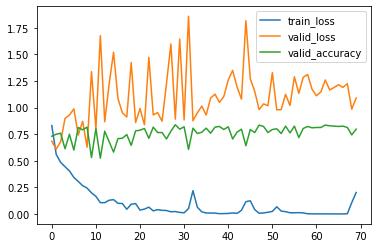

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8139549335664563
TEST
loss: 0.8243991901004125
accuracy: 0.692063492063492
******************
epoch: 1
Train
0.6298628364222877
TEST
loss: 0.6330104873293922
accuracy: 0.7682539682539683
******************
epoch: 2
Train
0.5699748340535485
TEST
loss: 0.7612923913531833
accuracy: 0.7523809523809524
******************
epoch: 3
Train
0.5518647326516006
TEST
loss: 0.7276519332613264
accuracy: 0.726984126984127
******************
epoch: 4
Train
0.5393273342782491
TEST
loss: 0.7944822699304611
accuracy: 0.7047619047619048
******************
epoch: 5
Train
0.5366741997604809
TEST
loss: 0.5538474627903529
accuracy: 0.7968253968253968
******************
epoch: 6
Train
0.4835611104349753
TEST
loss: 0.8613588963236127
accuracy: 0.746031746031746
******************
epoch: 7
Train
0.4569838907483838
TEST
loss: 0.7338729375884646
accuracy: 0.7111111111111111
******************
epoch: 8
Train
0.4612510799888205
TEST
loss: 1.1593986104405116
accuracy: 0.6

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.868020304568528


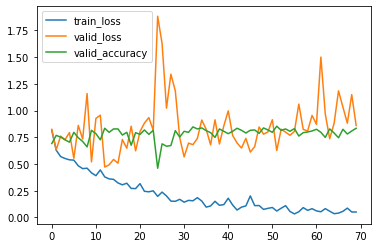

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0238537520904025
TEST
loss: 0.9629156089964367
accuracy: 0.7238095238095238
******************
epoch: 1
Train
0.6878256695293263
TEST
loss: 1.7321252565535288
accuracy: 0.43492063492063493
******************
epoch: 2
Train
0.6507972553194847
TEST
loss: 1.3392334786672442
accuracy: 0.5333333333333333
******************
epoch: 3
Train
0.6683569325635697
TEST
loss: 0.6791316874443538
accuracy: 0.7682539682539683
******************
epoch: 4
Train
0.5921753639735524
TEST
loss: 0.6376907901158408
accuracy: 0.765079365079365
******************
epoch: 5
Train
0.6022021192894558
TEST
loss: 0.6218332457163978
accuracy: 0.7523809523809524
******************
epoch: 6
Train
0.5612364733758856
TEST
loss: 0.6340542636220418
accuracy: 0.7492063492063492
******************
epoch: 7
Train
0.5920101808734693
TEST
loss: 0.631046163846576
accuracy: 0.7682539682539683
******************
epoch: 8
Train
0.5945376438977134
TEST
loss: 0.6255370832624889
accuracy: 0

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


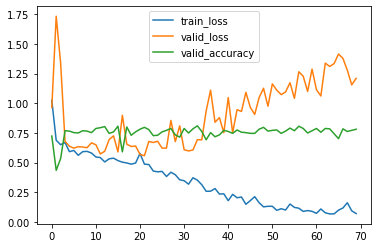

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8220287267417544
TEST
loss: 0.7830660759456574
accuracy: 0.7333333333333333
******************
epoch: 1
Train
0.6170173848877831
TEST
loss: 0.591531461193448
accuracy: 0.7873015873015873
******************
epoch: 2
Train
0.5956762031584718
TEST
loss: 0.6972515524379791
accuracy: 0.7555555555555555
******************
epoch: 3
Train
0.5689272967428324
TEST
loss: 0.6923716372913784
accuracy: 0.746031746031746
******************
epoch: 4
Train
0.5166735576674331
TEST
loss: 0.9053604614166987
accuracy: 0.7142857142857143
******************
epoch: 5
Train
0.5166292053257501
TEST
loss: 0.5171933440935044
accuracy: 0.8126984126984127
******************
epoch: 6
Train
0.4866830473196137
TEST
loss: 1.1188102133690365
accuracy: 0.726984126984127
******************
epoch: 7
Train
0.482300316321651
TEST
loss: 0.6901465224841284
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.4717510207197418
TEST
loss: 1.078767076371208
accuracy: 0.660

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8527918781725888


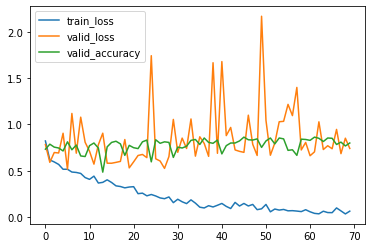

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0464398660197725
TEST
loss: 2.3440419348459396
accuracy: 0.28253968253968254
******************
epoch: 1
Train
0.7397770143341128
TEST
loss: 0.6532837411713979
accuracy: 0.7555555555555555
******************
epoch: 2
Train
0.6683704072374309
TEST
loss: 0.6808845535157219
accuracy: 0.7301587301587301
******************
epoch: 3
Train
0.6581560543740524
TEST
loss: 0.6193883765311469
accuracy: 0.7587301587301587
******************
epoch: 4
Train
0.635092177875843
TEST
loss: 0.6495407621065775
accuracy: 0.7587301587301587
******************
epoch: 5
Train
0.6120757928341509
TEST
loss: 0.5607611871901013
accuracy: 0.7873015873015873
******************
epoch: 6
Train
0.5854448482950497
TEST
loss: 0.6544531667043292
accuracy: 0.7619047619047619
******************
epoch: 7
Train
0.6059871841580078
TEST
loss: 0.597893536469293
accuracy: 0.780952380952381
******************
epoch: 8
Train
0.5740236777744188
TEST
loss: 0.6008871326370845
accuracy: 0.

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


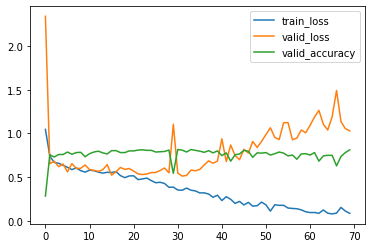

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.7907595531253042
TEST
loss: 2.2480246861775717
accuracy: 0.3904761904761905
******************
epoch: 1
Train
0.5556947580872309
TEST
loss: 0.6714121523357574
accuracy: 0.7492063492063492
******************
epoch: 2
Train
0.5184087127423457
TEST
loss: 0.706884877833109
accuracy: 0.7682539682539683
******************
epoch: 3
Train
0.4478880852058447
TEST
loss: 0.9046127841586158
accuracy: 0.7111111111111111
******************
epoch: 4
Train
0.43557851313597823
TEST
loss: 1.4956892208447532
accuracy: 0.6444444444444445
******************
epoch: 5
Train
0.4453075487903416
TEST
loss: 0.5874067418159
accuracy: 0.7873015873015873
******************
epoch: 6
Train
0.33971520429854357
TEST
loss: 0.7090914796269129
accuracy: 0.7714285714285715
******************
epoch: 7
Train
0.32126757109610216
TEST
loss: 0.5666972005178058
accuracy: 0.8063492063492064
******************
epoch: 8
Train
0.33134012093517495
TEST
loss: 0.9946524483816964
accuracy: 

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8604060913705583


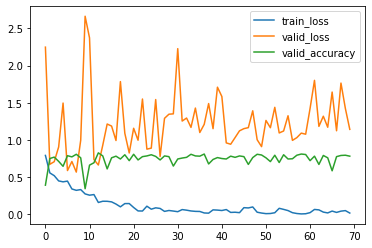

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.7765227421774952
TEST
loss: 0.9349538617663913
accuracy: 0.6730158730158731
******************
epoch: 1
Train
0.5741805820544624
TEST
loss: 0.8671217299643017
accuracy: 0.6793650793650794
******************
epoch: 2
Train
0.5197482385078624
TEST
loss: 0.6737695794256907
accuracy: 0.7587301587301587
******************
epoch: 3
Train
0.4520698976810249
TEST
loss: 0.6242498797083658
accuracy: 0.765079365079365
******************
epoch: 4
Train
0.47263202258194126
TEST
loss: 0.9071398333897667
accuracy: 0.7555555555555555
******************
epoch: 5
Train
0.43000670166788263
TEST
loss: 0.6361797342224726
accuracy: 0.7904761904761904
******************
epoch: 6
Train
0.36271481141388845
TEST
loss: 0.6786302082122319
accuracy: 0.7619047619047619
******************
epoch: 7
Train
0.37133078470033154
TEST
loss: 0.6446539979132395
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.323502423982946
TEST
loss: 0.809404971107604
accuracy:

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


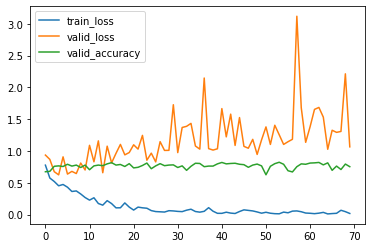

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.7708100510363166
TEST
loss: 0.6867130260618907
accuracy: 0.7174603174603175
******************
epoch: 1
Train
0.5663943595124957
TEST
loss: 0.8462855446906317
accuracy: 0.6825396825396826
******************
epoch: 2
Train
0.5528075432758468
TEST
loss: 1.3753371261415028
accuracy: 0.5301587301587302
******************
epoch: 3
Train
0.4628422016232046
TEST
loss: 0.7891286874574328
accuracy: 0.7206349206349206
******************
epoch: 4
Train
0.44549048197847024
TEST
loss: 1.0446216872760228
accuracy: 0.6888888888888889
******************
epoch: 5
Train
0.4070896303682123
TEST
loss: 0.7557427729879107
accuracy: 0.746031746031746
******************
epoch: 6
Train
0.3029919742022932
TEST
loss: 0.6428732458561186
accuracy: 0.7365079365079366
******************
epoch: 7
Train
0.3188572605159001
TEST
loss: 0.5576537113341075
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.26318790748821924
TEST
loss: 1.1037592013676962
accuracy:

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8477157360406091


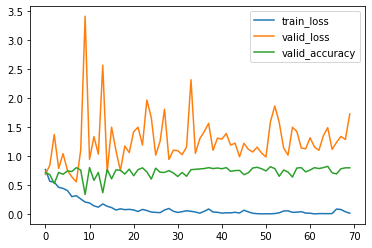

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.7872473661676108
TEST
loss: 0.6715615281983027
accuracy: 0.726984126984127
******************
epoch: 1
Train
0.5568107120852512
TEST
loss: 1.0758229161065722
accuracy: 0.6507936507936508
******************
epoch: 2
Train
0.5369865172812633
TEST
loss: 0.6112204322739253
accuracy: 0.780952380952381
******************
epoch: 3
Train
0.47232629220290634
TEST
loss: 0.854415426178584
accuracy: 0.7238095238095238
******************
epoch: 4
Train
0.42885403329176597
TEST
loss: 0.7401386238279797
accuracy: 0.7301587301587301
******************
epoch: 5
Train
0.3771025486130673
TEST
loss: 0.7281389435132345
accuracy: 0.7714285714285715
******************
epoch: 6
Train
0.3224939067416763
TEST
loss: 0.894756589806269
accuracy: 0.546031746031746
******************
epoch: 7
Train
0.2818859301099141
TEST
loss: 2.285137282855927
accuracy: 0.707936507936508
******************
epoch: 8
Train
0.2685790349795195
TEST
loss: 1.8254841331451659
accuracy: 0.698

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8426395939086294


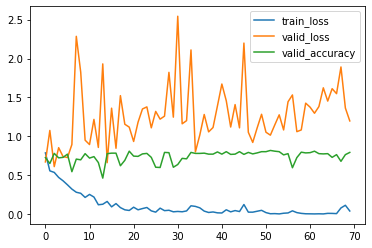

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.7650281356098729
TEST
loss: 0.8852344815693204
accuracy: 0.6317460317460317
******************
epoch: 1
Train
0.6113053645947512
TEST
loss: 1.1893520434697469
accuracy: 0.526984126984127
******************
epoch: 2
Train
0.542216257692993
TEST
loss: 0.9485993786463662
accuracy: 0.6317460317460317
******************
epoch: 3
Train
0.5003145034584003
TEST
loss: 0.5822203638061645
accuracy: 0.7587301587301587
******************
epoch: 4
Train
0.4581996999485707
TEST
loss: 1.524531570881132
accuracy: 0.6761904761904762
******************
epoch: 5
Train
0.4145351841252791
TEST
loss: 0.694741450037275
accuracy: 0.7777777777777778
******************
epoch: 6
Train
0.39420163496512095
TEST
loss: 0.5888440904163179
accuracy: 0.7238095238095238
******************
epoch: 7
Train
0.3726268665150483
TEST
loss: 1.2640339009345525
accuracy: 0.6698412698412698
******************
epoch: 8
Train
0.3365167315703143
TEST
loss: 0.5741236075522408
accuracy: 0.7

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8426395939086294


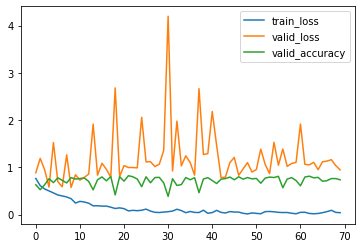

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9025123312986494
TEST
loss: 0.6621825237122793
accuracy: 0.7523809523809524
******************
epoch: 1
Train
0.6461960150193752
TEST
loss: 0.7284970351627895
accuracy: 0.6857142857142857
******************
epoch: 2
Train
0.5798534496233897
TEST
loss: 0.645383830297561
accuracy: 0.7174603174603175
******************
epoch: 3
Train
0.4983141301784182
TEST
loss: 0.5526628511292594
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.4798211280650047
TEST
loss: 1.2085548323298259
accuracy: 0.6698412698412698
******************
epoch: 5
Train
0.4586150459442184
TEST
loss: 0.612478968832228
accuracy: 0.7904761904761904
******************
epoch: 6
Train
0.3870422127608556
TEST
loss: 0.8075018146681407
accuracy: 0.7428571428571429
******************
epoch: 7
Train
0.416619537793236
TEST
loss: 1.9885749563338264
accuracy: 0.6444444444444445
******************
epoch: 8
Train
0.3482925629833561
TEST
loss: 0.6106823998784262
accuracy: 0.7

In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8223350253807107


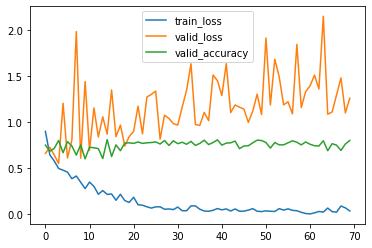

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()